# DQN from scratch

[Source](https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/01.dqn.ipynb). There are three key algorithmic features which contribute to the stability of DQN:  
1. Replay Buffer
2. Fixed Target Network
3. Gradient Clipping

## Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [16]:
import time
import highway_env
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from abc import abstractmethod, ABC
from typing import Dict, List, Tuple
from IPython.display import clear_output

from agents import BaseDQNAgent

## Replay Buffer

In this simple implementation of a Replay Buffer, samples are drawn uniformly with no priority.

In [3]:
class ReplayBuffer:
    """
    Class representing a simple replay buffer that accepts stacked images.
    """
    
    def __init__(self, obs_shape: Tuple, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, *obs_shape], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, *obs_shape], dtype=np.float32)

        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.max_size = size
        self.batch_size = batch_size

        self.ptr = 0
        self.size = 0

    def store(self, obs: np.ndarray, act: np.ndarray, rew: np.ndarray, next_obs: np.ndarray, done: bool):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        # Draw `batch_size` no. samples (without replacement) as indices.
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            indices=idxs,
        )
    
    def __len__(self) -> int:
        return self.size

## Network

Contains three fully connected layers and two activation (non-linearity) functions.

In [4]:
class Network(nn.Module):
    """
    Class representing a feed-forward multi-layered percepton.
    """

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a three-layer feed-forward neural network.
        """
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        return self.layers(x)

## DQN Agent

In [5]:
class MlpDQNAgent(BaseDQNAgent):
    """
    Class representing a DQN agent utilising MLP Feed-Forward Neural Networks.
    """

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float = 1e-4,
        seed: int = 42,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            epsilon_decay, 
            seed, 
            max_epsilon, 
            min_epsilon, 
            gamma
        )

        # Networks: DQN behaviour network, DQN target network
        self.obs_dim = np.prod(self.obs_shape)
        self.dqn = Network(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target = Network(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        """
        Selects an action from the input state using an epsilon-greedy policy.
        """
        if not determinstic and np.random.random() < self.epsilon:
            selected_action = self.env.action_space.sample()
        else:
            flattened_state = state.flatten()
            selected_action = self.dqn(
                torch.FloatTensor(flattened_state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float = None) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        if gamma is None:
            gamma = self.gamma

        device = self.device
        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

# Train an agent

In [7]:
config = {
    'duration': 50,
    'lanes_count': 4,
}

In [8]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [12]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = MlpDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


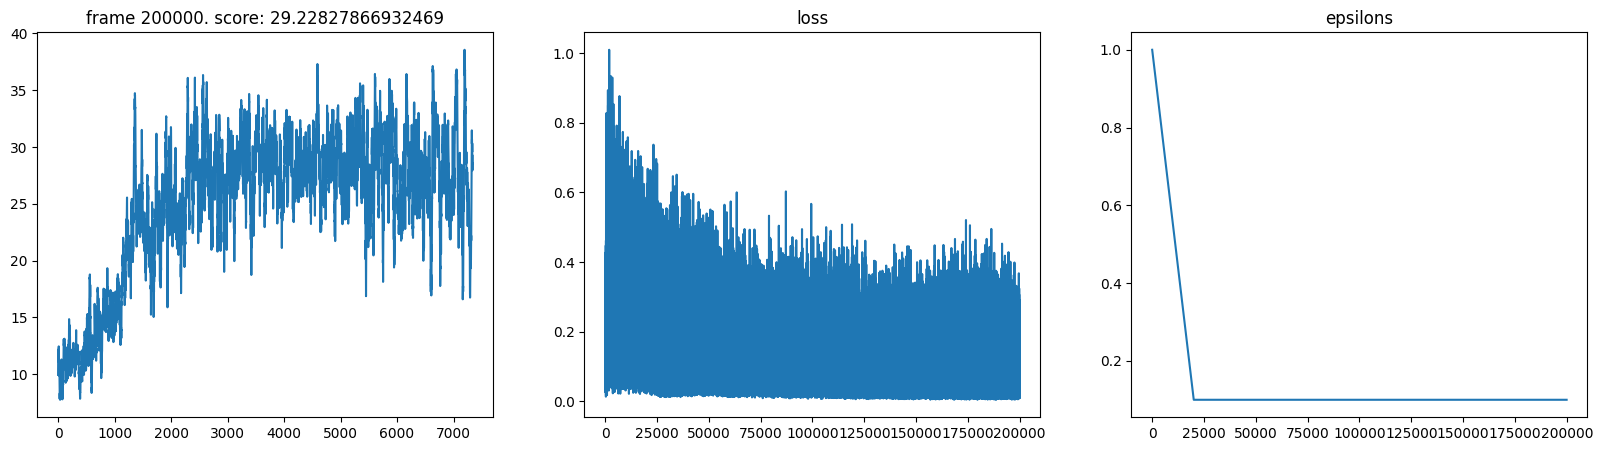

In [13]:
scores, losses, epsilons = agent.train(num_frames)

In [31]:
pd.DataFrame(dict(DQN=scores)).to_csv("../results/dqn.csv")

# Test the agent

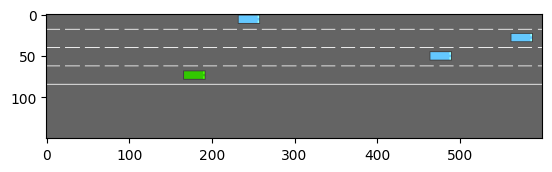

In [14]:
ep_lens, ep_rews = agent.test(5, time_interval=0.1)

In [15]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 46.6
Mean Score Per Episode: 44.28765789426858
